In [1]:
# 1. Thêm các thư viện cần thiết
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import joblib
from datetime import datetime

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Dropout, Flatten, Dense
)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

2025-11-24 14:34:38.596151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763994878.805177      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763994878.862359      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# 2. Load dữ liệu

# Hàm load dữ liệu
def load_dataset_from_dir(data_dir, img_size=(64,64)):
    X, y = [], []
    # Lấy list các thư mục con (tên lớp) và xây label_map
    classes = sorted(d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d)))
    label_map = {cls:i for i,cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                path = os.path.join(cls_dir, fname)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)                   
                img = img.astype(np.float16) / 255.0              
                X.append(img)
                y.append(cls)                                     

    X = np.array(X)                                         
    y = np.array(y)

    return X, y, label_map

dataset_path_train = '/kaggle/input/cs231-gridsearch/Vietnam-Traffic-Sign-Classification-main/Vietnam-Traffic-Sign-Classification-main/vn-signs/train'
dataset_path_test = '/kaggle/input/cs231-gridsearch/Vietnam-Traffic-Sign-Classification-main/Vietnam-Traffic-Sign-Classification-main/vn-signs/test'

# Load train/test
X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(256,256))
X_test,  y_test,  label_map_test  = load_dataset_from_dir(dataset_path_test,  img_size=(256,256))

print(label_map_train)
print(f"Số ảnh train: {len(X_train)}")
print(f"Số ảnh test: {len(X_test)}")

{'Cam': 0, 'Chidan': 1, 'Hieulenh': 2, 'Nguyhiem': 3, 'Phu': 4}
Số ảnh train: 1344
Số ảnh test: 153


In [3]:
# 3. Encode nhãn và split train
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num  = le.transform(y_test)
num_classes = len(le.classes_)

# ─── Kiểm tra bộ mã hoá LabelEncoder ───
print(y_train_num)
print(y_test_num)

[0 0 0 ... 4 4 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4]


In [4]:
from sklearn.model_selection import train_test_split

# Chia tập train thành 2 phần: train(80%) và valid(20%)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num,
    test_size=0.2, random_state=42,
    stratify=y_train_num
)

print(f"Số ảnh TRAIN: {len(X_train_sub)}")
print(f"Số ảnh VALIDATION: {len(X_val)}")

Số ảnh TRAIN: 1075
Số ảnh VALIDATION: 269


In [5]:
# 4. One‑hot encode Y
Y_train = to_categorical(y_train_sub, num_classes)
Y_val   = to_categorical(y_val,         num_classes)
Y_test  = to_categorical(y_test_num,    num_classes)

print(Y_train)
print(Y_val)
print(Y_test)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.

In [6]:
# 5. Định nghĩa Mô hình VGG16 (Transfer Learning)

# Định nghĩa kích thước input (phải khớp với img_size bạn đã load ở trên)
# Trong code cũ bạn đang dùng (256, 256) 
input_shape = (256, 256, 3)

# Tải VGG16 đã pre-train trên ImageNet
# include_top=False nghĩa là bỏ lớp phân loại cuối cùng của VGG (1000 lớp) để thay bằng lớp của mình
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Đóng băng (Freeze) các lớp của base_model để không train lại từ đầu
# Giúp giữ lại các đặc trưng đã học và giảm thời gian train
base_model.trainable = False 

# Xây dựng phần "đầu" (Head) mới cho bài toán biển báo Việt Nam
inputs = Input(shape=input_shape)

# Đưa input qua VGG16 base
# training=False để đảm bảo các lớp BatchNormalization chạy ở chế độ inference
x = base_model(inputs, training=False)

# Làm phẳng dữ liệu (Có thể dùng Flatten hoặc GlobalAveragePooling2D)
x = Flatten()(x)

# Lớp ẩn (Fully Connected)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Giữ nguyên dropout để chống Overfitting [cite: 10]

# Lớp đầu ra (Output layer)
outputs = Dense(num_classes, activation='softmax')(x)

# Kết hợp lại thành model hoàn chỉnh
model = Model(inputs, outputs)

model.summary()

I0000 00:00:1763994911.664994      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,104,837 (88.14 MB)

 Trainable params: 8,390,149 (32.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True) 
]

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Thực hiện train model với data
H = model.fit(
    X_train_sub, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=30,
    callbacks=callbacks,
    verbose=1,
)

# ─── Lưu lại model và kết quả ───
results_dir = "cnn_results"
os.makedirs(results_dir, exist_ok=True)

# Lưu model
model_path = os.path.join(results_dir, "traffic_sign_cnn_model.keras")
model.save(model_path)
print(f"✅ Đã lưu model: {model_path}")

# Lưu training history
import pickle
history_path = os.path.join(results_dir, "training_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(H.history, f)
print(f"✅ Đã lưu training history: {history_path}")

# Lưu label encoder
import joblib
le_path = os.path.join(results_dir, "label_encoder.pkl")
joblib.dump(le, le_path)
print(f"✅ Đã lưu label encoder: {le_path}")

Epoch 1/30


I0000 00:00:1763994920.310938     113 service.cc:148] XLA service 0x7de55800e880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763994920.311634     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763994920.677162     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/34 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.1719 - loss: 3.5845

I0000 00:00:1763994932.418796     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4642 - loss: 2.5344

E0000 00:00:1763994938.967366     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763994939.204205     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763994940.172047     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763994940.432906     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4687 - loss: 2.5044

E0000 00:00:1763994947.551142     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763994947.786578     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763994948.582377     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763994948.841076     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 553ms/step - accuracy: 0.4730 - loss: 2.4761 - val_accuracy: 0.8439 - val_loss: 0.4512
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.8430 - loss: 0.4286 - val_accuracy: 0.8885 - val_loss: 0.3222
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9099 - loss: 0.2538 - val_accuracy: 0.8736 - val_loss: 0.2959
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9158 - loss: 0.2253 - val_accuracy: 0.9033 - val_loss: 0.2410
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9380 - loss: 0.1615 - val_accuracy: 0.9442 - val_loss: 0.1720
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9538 - loss: 0.1361 - val_accuracy: 0.9294 - val_loss: 0.1927
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9683 - loss: 0.1134 - val_accuracy: 0.9442 - val_loss: 0.1743
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9732 - loss: 0.0848 - val_accuracy: 0.9368 - val

✅ Đã lưu training plots: cnn_results/training_history_20251124_143647.png


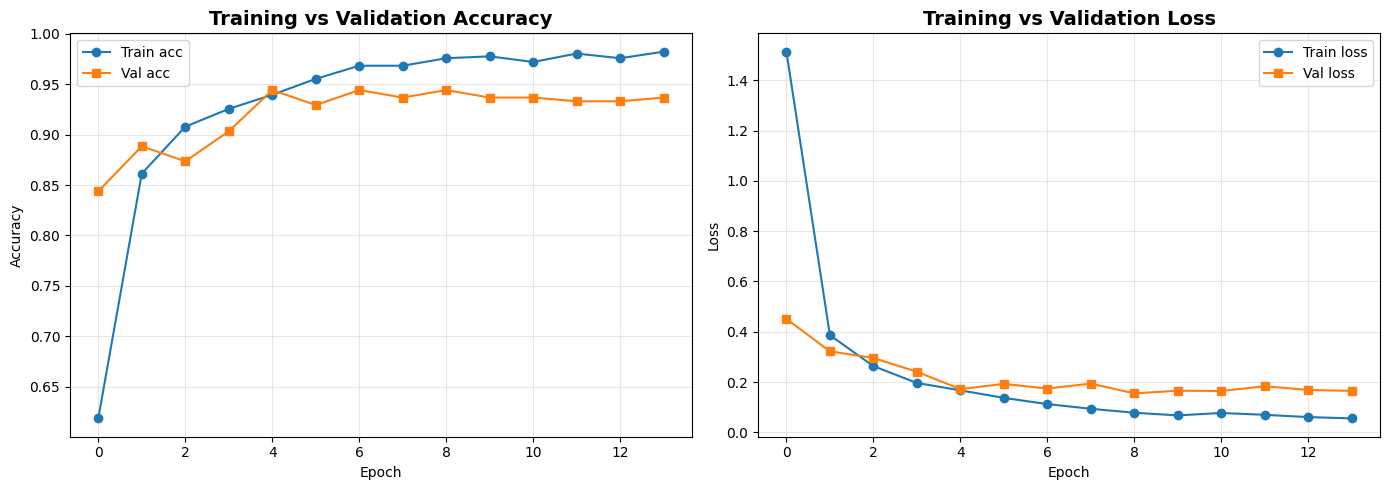

In [8]:
# 9. Vẽ đồ thị loss và accuracy của training & validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Accuracy
ax1.plot(H.history['accuracy'], label='Train acc', marker='o')
ax1.plot(H.history['val_accuracy'], label='Val acc', marker='s')
ax1.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(H.history['loss'], label='Train loss', marker='o')
ax2.plot(H.history['val_loss'], label='Val loss', marker='s')
ax2.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Lưu figure
training_plot_path = os.path.join(results_dir, f"training_history_{timestamp}.png")
plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Đã lưu training plots: {training_plot_path}")

plt.show()


In [9]:
# Chuyển y_test từ tên lớp → số nguyên
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

target_names = le.classes_  # lấy tên lớp đúng thứ tự đã mã hoá

print("=== Classification Report on Test Set ===")
print(classification_report(y_test_num, y_test_pred, target_names=target_names))


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

E0000 00:00:1763995013.567057     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763995013.805705     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763995014.962093     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763995015.225331     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 
=== Classification Report on Test Set ===
              precision    recall  f1-score   support

         Cam       0.94      1.00      0.97        33
      Chidan       0.89      0.89      0.89        36
    Hieulenh       0.87      0.84      0.86        32
    Nguyhiem       1.00      0.97      0.98        29
         Phu       0.91      0.91      0.91        23

    accuracy                           0.92       153
   macro avg       0.92      0.92      0.92       153
weighted avg       0.92      0.92      0.92       153



In [10]:
# ─── Lưu kết quả evaluation ───
from datetime import datetime

# Tạo timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Lưu classification report
report_path = os.path.join(results_dir, f"classification_report_{timestamp}.txt")
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("CNN MODEL - CLASSIFICATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: traffic_sign_cnn_model.keras\n")
    f.write(f"Image size: 64x64\n")
    f.write(f"Classes: {list(le.classes_)}\n\n")
    f.write("=" * 80 + "\n")
    f.write("TEST SET RESULTS\n")
    f.write("=" * 80 + "\n\n")
    f.write(classification_report(y_test_num, y_test_pred, target_names=target_names))
    f.write("\n\n")
    f.write("=" * 80 + "\n")
    f.write("TRAINING HISTORY\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Final Train Accuracy: {H.history['accuracy'][-1]:.4f}\n")
    f.write(f"Final Val Accuracy: {H.history['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final Train Loss: {H.history['loss'][-1]:.4f}\n")
    f.write(f"Final Val Loss: {H.history['val_loss'][-1]:.4f}\n")
    f.write(f"Total Epochs: {len(H.history['accuracy'])}\n")

print(f"✅ Đã lưu classification report: {report_path}")

# Lưu predictions
predictions_path = os.path.join(results_dir, f"test_predictions_{timestamp}.pkl")
with open(predictions_path, 'wb') as f:
    pickle.dump({
        'y_true': y_test_num,
        'y_pred': y_test_pred,
        'y_pred_prob': y_test_pred_prob,
        'class_names': target_names
    }, f)
print(f"✅ Đã lưu predictions: {predictions_path}")


✅ Đã lưu classification report: cnn_results/classification_report_20251124_143657.txt
✅ Đã lưu predictions: cnn_results/test_predictions_20251124_143657.pkl



PHÂN TÍCH ẢNH DỰ ĐOÁN SAI
Tổng số ảnh test: 153
Số ảnh dự đoán SAI: 12
Số ảnh dự đoán ĐÚNG: 141
Tỷ lệ sai: 7.84%

CHI TIẾT CÁC ẢNH DỰ ĐOÁN SAI:

1. Ảnh #43:
   ✓ Nhãn thật:     Chidan
   ✗ Nhãn dự đoán:  Hieulenh (confidence: 52.13%)
   Top 3 predictions:
      1. Hieulenh: 52.13%
      2. Chidan: 34.06%
      3. Phu: 11.30%

2. Ảnh #57:
   ✓ Nhãn thật:     Chidan
   ✗ Nhãn dự đoán:  Hieulenh (confidence: 44.08%)
   Top 3 predictions:
      1. Hieulenh: 44.08%
      2. Phu: 35.97%
      3. Chidan: 19.90%

3. Ảnh #61:
   ✓ Nhãn thật:     Chidan
   ✗ Nhãn dự đoán:  Hieulenh (confidence: 41.39%)
   Top 3 predictions:
      1. Hieulenh: 41.39%
      2. Chidan: 34.57%
      3. Phu: 24.04%

4. Ảnh #63:
   ✓ Nhãn thật:     Chidan
   ✗ Nhãn dự đoán:  Hieulenh (confidence: 85.77%)
   Top 3 predictions:
      1. Hieulenh: 85.77%
      2. Phu: 7.34%
      3. Chidan: 4.43%

5. Ảnh #80:
   ✓ Nhãn thật:     Hieulenh
   ✗ Nhãn dự đoán:  Phu (confidence: 73.43%)
   Top 3 predictions:
      1. Phu: 73

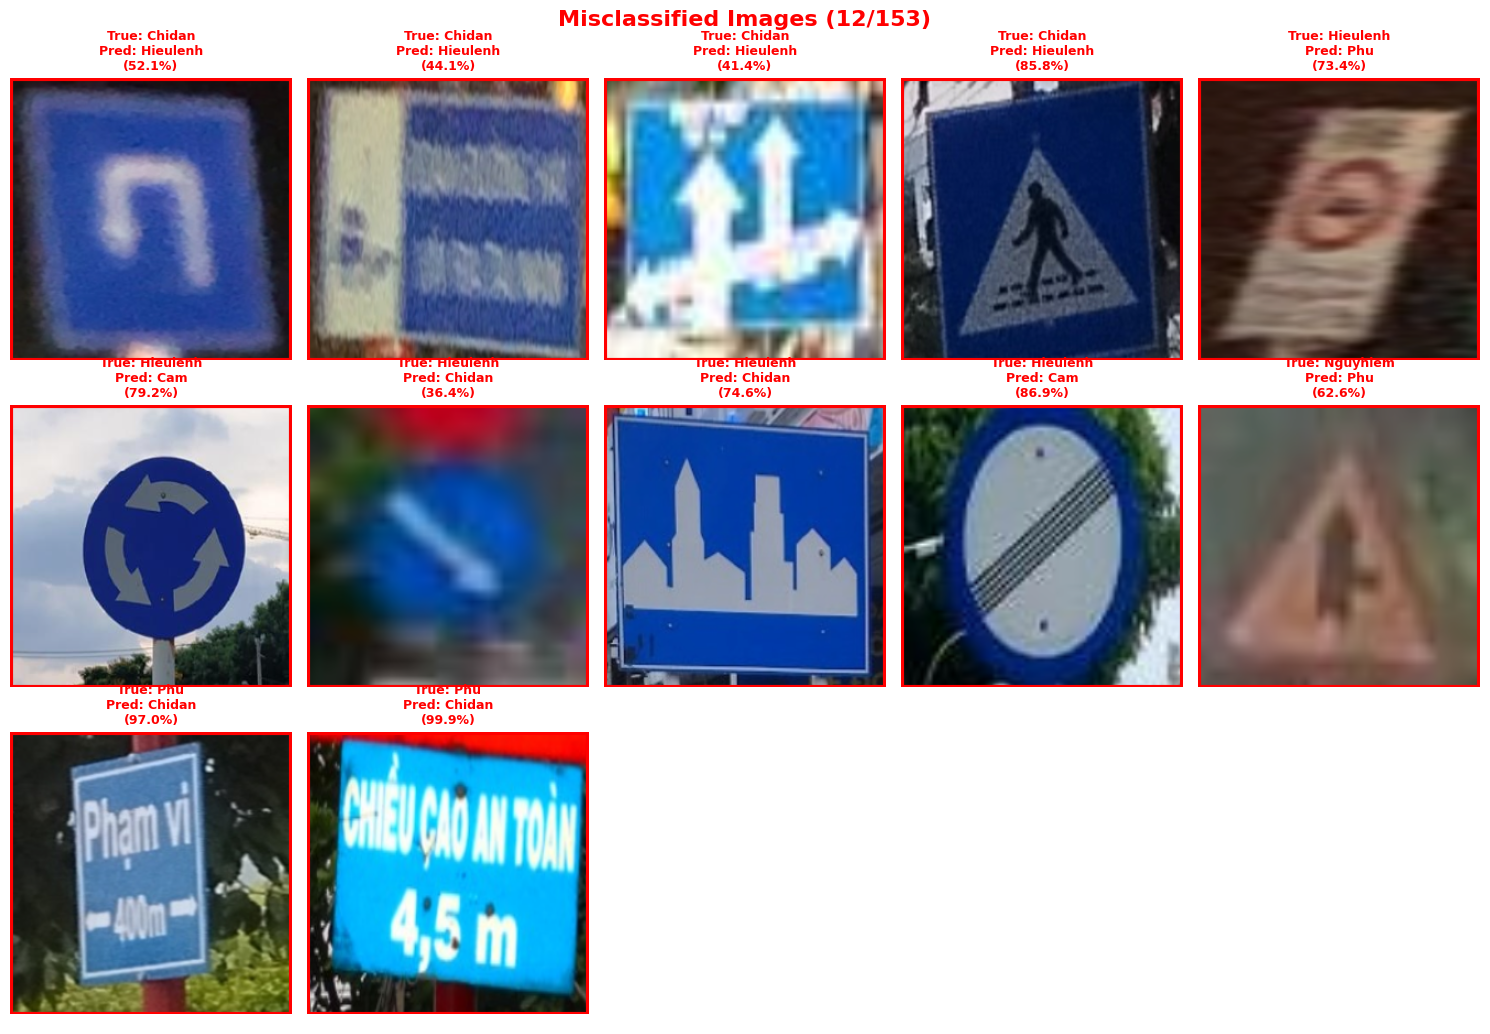


ĐANG LƯU TỪNG ẢNH RIÊNG LẺ...

  1/12. Đã lưu: img043_true-Chidan_pred-Hieulenh_52%.png
  2/12. Đã lưu: img057_true-Chidan_pred-Hieulenh_44%.png
  3/12. Đã lưu: img061_true-Chidan_pred-Hieulenh_41%.png
  4/12. Đã lưu: img063_true-Chidan_pred-Hieulenh_86%.png
  5/12. Đã lưu: img080_true-Hieulenh_pred-Phu_73%.png
  6/12. Đã lưu: img085_true-Hieulenh_pred-Cam_79%.png
  7/12. Đã lưu: img094_true-Hieulenh_pred-Chidan_36%.png
  8/12. Đã lưu: img097_true-Hieulenh_pred-Chidan_75%.png
  9/12. Đã lưu: img100_true-Hieulenh_pred-Cam_87%.png
  10/12. Đã lưu: img110_true-Nguyhiem_pred-Phu_63%.png
  11/12. Đã lưu: img143_true-Phu_pred-Chidan_97%.png
  12/12. Đã lưu: img147_true-Phu_pred-Chidan_100%.png

✅ Đã lưu báo cáo chi tiết: cnn_results/misclassified_images/misclassified_report_20251124_143657.txt

✅ HOÀN THÀNH!

Đã lưu vào thư mục: cnn_results/misclassified_images/
  - Overview image: misclassified_overview_20251124_143657.png
  - Individual images: 12 files
  - Detailed report: misclassified_

In [11]:
# ─── Phân tích và lưu ảnh bị phân loại SAI ───
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Tìm các ảnh dự đoán sai
wrong_indices = np.where(y_test_num != y_test_pred)[0]
print(f"\n{'='*80}")
print(f"PHÂN TÍCH ẢNH DỰ ĐOÁN SAI")
print(f"{'='*80}")
print(f"Tổng số ảnh test: {len(y_test_num)}")
print(f"Số ảnh dự đoán SAI: {len(wrong_indices)}")
print(f"Số ảnh dự đoán ĐÚNG: {len(y_test_num) - len(wrong_indices)}")
print(f"Tỷ lệ sai: {len(wrong_indices)/len(y_test_num)*100:.2f}%")

if len(wrong_indices) > 0:
    # Tạo thư mục lưu ảnh sai
    misclassified_dir = os.path.join(results_dir, "misclassified_images")
    os.makedirs(misclassified_dir, exist_ok=True)
    
    print(f"\n{'='*80}")
    print(f"CHI TIẾT CÁC ẢNH DỰ ĐOÁN SAI:")
    print(f"{'='*80}\n")
    
    # Hiển thị chi tiết từng ảnh sai
    for i, idx in enumerate(wrong_indices, 1):
        true_label = target_names[y_test_num[idx]]
        pred_label = target_names[y_test_pred[idx]]
        confidence = y_test_pred_prob[idx][y_test_pred[idx]]
        
        print(f"{i}. Ảnh #{idx}:")
        print(f"   ✓ Nhãn thật:     {true_label}")
        print(f"   ✗ Nhãn dự đoán:  {pred_label} (confidence: {confidence:.2%})")
        print(f"   Top 3 predictions:")
        top3_idx = np.argsort(y_test_pred_prob[idx])[-3:][::-1]
        for rank, class_idx in enumerate(top3_idx, 1):
            print(f"      {rank}. {target_names[class_idx]}: {y_test_pred_prob[idx][class_idx]:.2%}")
        print()
    
    # Vẽ tất cả ảnh sai trong một figure lớn
    n_wrong = len(wrong_indices)
    n_cols = min(5, n_wrong)
    n_rows = (n_wrong + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3.5))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(wrong_indices):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Hiển thị ảnh (chuyển sang float32 để matplotlib render được)
        img = X_test[idx].astype(np.float32)
        ax.imshow(img)
        
        # Thông tin
        true_label = target_names[y_test_num[idx]]
        pred_label = target_names[y_test_pred[idx]]
        confidence = y_test_pred_prob[idx][y_test_pred[idx]]
        
        # Title với màu đỏ
        title = f"True: {true_label}\nPred: {pred_label}\n({confidence:.1%})"
        ax.set_title(title, fontsize=9, color='red', fontweight='bold')
        ax.axis('off')
        
        # Thêm border đỏ
        rect = patches.Rectangle((0, 0), img.shape[1]-1, img.shape[0]-1, 
                                 linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    # Ẩn các subplot trống
    for i in range(n_wrong, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        ax.axis('off')
    
    plt.suptitle(f'Misclassified Images ({n_wrong}/{len(y_test_num)})', 
                 fontsize=16, fontweight='bold', color='red')
    plt.tight_layout()
    
    # Lưu figure tổng hợp
    misclassified_overview_path = os.path.join(misclassified_dir, f"misclassified_overview_{timestamp}.png")
    plt.savefig(misclassified_overview_path, dpi=300, bbox_inches='tight')
    print(f"✅ Đã lưu overview: {misclassified_overview_path}")
    plt.show()
    
    # Lưu từng ảnh riêng lẻ với thông tin chi tiết
    print(f"\n{'='*80}")
    print(f"ĐANG LƯU TỪNG ẢNH RIÊNG LẺ...")
    print(f"{'='*80}\n")
    
    for i, idx in enumerate(wrong_indices, 1):
        true_label = target_names[y_test_num[idx]]
        pred_label = target_names[y_test_pred[idx]]
        confidence = y_test_pred_prob[idx][y_test_pred[idx]]
        
        # Tạo figure cho từng ảnh
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        # Hiển thị ảnh (chuyển sang float32 để matplotlib render được)
        img = X_test[idx].astype(np.float32)
        ax.imshow(img)
        
        # Title chi tiết
        title = (f"Image #{idx}\n"
                f"True Label: {true_label}\n"
                f"Predicted: {pred_label} ({confidence:.2%})")
        ax.set_title(title, fontsize=12, fontweight='bold', color='red')
        ax.axis('off')
        
        # Thêm border đỏ
        rect = patches.Rectangle((0, 0), img.shape[1]-1, img.shape[0]-1, 
                                 linewidth=4, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Thêm text box với top predictions
        textstr = "Top 3 Predictions:\n"
        top3_idx = np.argsort(y_test_pred_prob[idx])[-3:][::-1]
        for rank, class_idx in enumerate(top3_idx, 1):
            prob = y_test_pred_prob[idx][class_idx]
            textstr += f"{rank}. {target_names[class_idx]}: {prob:.2%}\n"
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        
        # Tên file
        filename = f"img{idx:03d}_true-{true_label}_pred-{pred_label}_{confidence:.0%}.png"
        filepath = os.path.join(misclassified_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  {i}/{n_wrong}. Đã lưu: {filename}")
    
    # Lưu thông tin chi tiết vào file text
    misclassified_report_path = os.path.join(misclassified_dir, f"misclassified_report_{timestamp}.txt")
    with open(misclassified_report_path, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("MISCLASSIFIED IMAGES REPORT\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total test images: {len(y_test_num)}\n")
        f.write(f"Misclassified: {len(wrong_indices)}\n")
        f.write(f"Correctly classified: {len(y_test_num) - len(wrong_indices)}\n")
        f.write(f"Error rate: {len(wrong_indices)/len(y_test_num)*100:.2f}%\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("DETAILED MISCLASSIFICATIONS\n")
        f.write("=" * 80 + "\n\n")
        
        for i, idx in enumerate(wrong_indices, 1):
            true_label = target_names[y_test_num[idx]]
            pred_label = target_names[y_test_pred[idx]]
            confidence = y_test_pred_prob[idx][y_test_pred[idx]]
            
            f.write(f"{i}. Image #{idx}\n")
            f.write(f"   True Label:      {true_label}\n")
            f.write(f"   Predicted Label: {pred_label}\n")
            f.write(f"   Confidence:      {confidence:.2%}\n")
            f.write(f"   \n")
            f.write(f"   Top 3 Predictions:\n")
            top3_idx = np.argsort(y_test_pred_prob[idx])[-3:][::-1]
            for rank, class_idx in enumerate(top3_idx, 1):
                prob = y_test_pred_prob[idx][class_idx]
                f.write(f"      {rank}. {target_names[class_idx]}: {prob:.2%}\n")
            f.write("\n")
        
        # Thống kê theo loại lỗi
        f.write("\n" + "=" * 80 + "\n")
        f.write("ERROR STATISTICS BY CLASS\n")
        f.write("=" * 80 + "\n\n")
        
        for true_class_idx, true_class_name in enumerate(target_names):
            # Tìm các ảnh của lớp này bị dự đoán sai
            class_wrong = [idx for idx in wrong_indices if y_test_num[idx] == true_class_idx]
            if len(class_wrong) > 0:
                total_class = np.sum(y_test_num == true_class_idx)
                f.write(f"\n{true_class_name}:\n")
                f.write(f"  Total: {total_class}, Misclassified: {len(class_wrong)} ({len(class_wrong)/total_class*100:.1f}%)\n")
                f.write(f"  Confused with:\n")
                
                # Đếm nhầm với lớp nào
                for pred_class_idx, pred_class_name in enumerate(target_names):
                    if pred_class_idx != true_class_idx:
                        count = sum(1 for idx in class_wrong if y_test_pred[idx] == pred_class_idx)
                        if count > 0:
                            f.write(f"    - {pred_class_name}: {count} times\n")
    
    print(f"\n✅ Đã lưu báo cáo chi tiết: {misclassified_report_path}")
    
    print(f"\n{'='*80}")
    print(f"✅ HOÀN THÀNH!")
    print(f"{'='*80}")
    print(f"\nĐã lưu vào thư mục: {misclassified_dir}/")
    print(f"  - Overview image: misclassified_overview_{timestamp}.png")
    print(f"  - Individual images: {len(wrong_indices)} files")
    print(f"  - Detailed report: misclassified_report_{timestamp}.txt")
    
else:
    print("\n🎉 HOÀN HẢO! Không có ảnh nào bị dự đoán sai!")


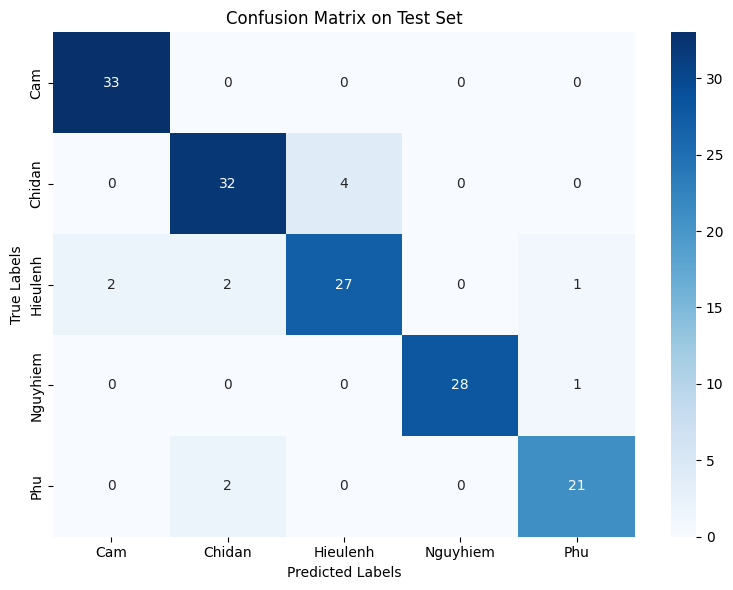

In [12]:
# 10. Vẽ Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_num, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

In [13]:
# ─── Lưu Confusion Matrix ───
# Lưu figure
cm_fig_path = os.path.join(results_dir, f"confusion_matrix_{timestamp}.png")
plt.savefig(cm_fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Đã lưu confusion matrix: {cm_fig_path}")

# Lưu confusion matrix data
cm_data_path = os.path.join(results_dir, f"confusion_matrix_{timestamp}.pkl")
with open(cm_data_path, 'wb') as f:
    pickle.dump({
        'confusion_matrix': cm,
        'class_names': target_names
    }, f)
print(f"✅ Đã lưu confusion matrix data: {cm_data_path}")

print("\n" + "=" * 80)
print("✅ ĐÃ LƯU TẤT CẢ KẾT QUẢ VÀO THỦ MỤC: cnn_results/")
print("=" * 80)
print("\nCác file đã lưu:")
print(f"  1. Model: traffic_sign_cnn_model.keras")
print(f"  2. Training history: training_history.pkl")
print(f"  3. Label encoder: label_encoder.pkl")
print(f"  4. Classification report: classification_report_{timestamp}.txt")
print(f"  5. Predictions: test_predictions_{timestamp}.pkl")
print(f"  6. Confusion matrix (PNG): confusion_matrix_{timestamp}.png")
print(f"  7. Confusion matrix (data): confusion_matrix_{timestamp}.pkl")


✅ Đã lưu confusion matrix: cnn_results/confusion_matrix_20251124_143657.png
✅ Đã lưu confusion matrix data: cnn_results/confusion_matrix_20251124_143657.pkl

✅ ĐÃ LƯU TẤT CẢ KẾT QUẢ VÀO THỦ MỤC: cnn_results/

Các file đã lưu:
  1. Model: traffic_sign_cnn_model.keras
  2. Training history: training_history.pkl
  3. Label encoder: label_encoder.pkl
  4. Classification report: classification_report_20251124_143657.txt
  5. Predictions: test_predictions_20251124_143657.pkl
  6. Confusion matrix (PNG): confusion_matrix_20251124_143657.png
  7. Confusion matrix (data): confusion_matrix_20251124_143657.pkl


<Figure size 640x480 with 0 Axes>